In [ ]:
%reset



In [ ]:
import os
import struct
import numpy as np
def load_mnist(path:str,kind:str="train")->np.array:
    labels_path = os.path.join(path,'%s-labels.idx1-ubyte' % kind)
    images_path = os.path.join(path,'%s-images.idx3-ubyte' % kind)
    with open(labels_path,'rb') as lbpath:
        magic,n = struct.unpack('>II',lbpath.read(8))
        labels = np.fromfile(lbpath,dtype=np.uint8)

    with open(images_path,'rb') as imgpath:
        magic,n,rows,cols=struct.unpack(">IIII",imgpath.read(16))
        images = np.fromfile(imgpath,dtype=np.uint8).reshape((len(labels),784))
        images = ((images/255.)-.5)
    return images,labels
X_train,y_train = load_mnist('', kind='byte_files/train')
X_train.shape

In [ ]:
X_test,y_test = load_mnist('', kind='byte_files/test')

In [ ]:
X_test

In [ ]:
X_train[y_train==1][0].reshape(28,28)

In [ ]:
import matplotlib.pyplot as plt
fig,ax = plt.subplots(nrows=2,ncols=5,sharex=True,sharey=True)

ax=ax.flatten()
for i in range(10):
    img =X_train[y_train==i][0].reshape(28,28)
    ax[i].imshow(img,cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
fig,ax = plt.subplots(
    nrows=5,
    ncols=5,
    sharey=True,
    sharex=True
)
ax=ax.flatten()
for i in range(25):
    img =X_train[y_train==7][i].reshape(28,28)
    ax[i].imshow(img,cmap='Greys')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()

In [ ]:
"""Компресс датасета в архив"""
np.savez_compressed("mnist_scaled.npz",
                    X_train=X_train,
                    y_train=y_train,
                    X_test=X_test,
                    y_test=y_test)


In [ ]:
"""чтение архива npz"""
mnist=np.load("mnist_scaled.npz")
mnist.files

In [ ]:
X_train=mnist['X_train']
X_train

In [ ]:
X_train, y_train, X_test, y_test = [mnist[f] for f in ['X_train', 'y_train',
                                    'X_test', 'y_test']]

del mnist

X_train.shape

In [ ]:
import sys
class NeuralNetMlp(object):
    """Нейронная сетья прямого распространения на основе классификатора
    многослойного персептрона
    Параметры
    ----------
    n_hidden : int (по умолчанию: 30)
        количество скрытых элементов

    l2 : float ( по умолчанию 0.)
        значение l2  регуляризации лямбда

    epochs : int (по умолчанию : 100)
        количество подходов к обучающему образцу

    eta : float (по умолчанию 0.001)
        скорость обучения
    shuffle : bool (по умолчанию True)
        тасовка входных данных
    minibatch_size : int( по умолчанию 1)
        Количество обучающих образцов на мини пакет
    seed : int (по умолчанию None)
        Случайные начальные значения для инициализации весов

    Атрибуты
    ---------
    eval_: dict
        словарь, в котором собираются показатели издержек,
        правильности при обучении и правильности при испытании
        для каждой эпохи во время обучения
        """

    def __init__(self, n_hidden=30, l2=0.,epochs=100,
                 eta=0.001, shuffle=True,minibatch_size=1, seed=None):
        self.random=np.random.RandomState(seed)
        self.n_hidden=n_hidden
        self.l2=l2
        self.epochs=epochs
        self.eta=eta
        self.shuffle=shuffle
        self.minibatch_size=minibatch_size

    def _onehot(self,y,n_classes):
        """кодирует метки с унитарным кодом"""

        onehot=np.zeros((n_classes,y.shape[0]))
        for idx,val in enumerate(y.astype(int)):
            onehot[val,idx]=1.
        return onehot.T

    def _sigmoid(self,z):
        return 1./(1.+np.exp(-np.clip(z,-250,250)))

    def _forward(self,X):
        # шаг 1 : общий вход скрытого слоя
        # скалярное произведение {n_examples, n_features}
        # и {n_features, n_hidden}
        # -> {n_examples, n_hidden]
        z_h = np.dot(X, self.w_h) + self.b_h
        #шаг 2: активация скрытого слоя
        a_h = self._sigmoid(z_h)
        # шаг 3: общий вход выходного слоя
        # скалярное произведение {n_examples, n_hidden}
        # и [n_hidden, п classlabels}
        # -> [n_examples, n_classlabels]
        z_out=np.dot(a_h,self.w_out)+self.b_out
        # шаг 4: активация выходного слоя
        a_out=self._sigmoid(z_out)
        return z_h,a_h,z_out,a_out

    def _compute_cost(self,y_enc,output):
        L2_term = (self.l2 *
                   (np.sum(self.w_h**2.)+np.sum(self.w_out**2.)))
        term1=-y_enc*(np.log(output))
        term2=(1.-y_enc)*np.log(1.-output)
        cost=np.sum(term1-term2)+L2_term
        return cost

    def predict(self,X):
        z_h,a_h,z_out,a_out=self._forward(X)
        y_pred=np.argmax(z_out,axis=1)
        return y_pred

    def fit(self,X_train,y_train,X_valid,y_valid):

        """инициализация"""
        n_output=np.unique(y_train).shape[0]
        n_features=X_train.shape[1]

        self.b_h=np.zeros(self.n_hidden)
        self.w_h=self.random.normal(loc=0.0,scale=0.1,
                                 size=(n_features,self.n_hidden))
        self.b_out=np.zeros(n_output)
        self.w_out=self.random.normal(loc=0.0,scale=0.1,
                                 size=(self.n_hidden,n_output))
        epoch_strlen=len(str(self.epochs))
        self.eval_={'cost':[],'train_acc':[],'valid_acc':[]}
        y_train_enc=self._onehot(y_train,n_output)

        for i in range(self.epochs):
            indices=np.arange(X_train.shape[0])

            if self.shuffle:
                self.random.shuffle(indices)

            for start_idx in range(0, indices.shape[0]- self.minibatch_size+
                                   1,self.minibatch_size):

                batch_idx=indices[start_idx:start_idx+self.minibatch_size]

                """прямое распространение"""
                z_h,a_h,z_out,a_out=self._forward(X_train[batch_idx])

                """обратное  распространение"""
                delta_out=a_out-y_train_enc[batch_idx]

                sigmoid_derivative_h=a_h*(1.-a_h)

                delta_h=(np.dot(delta_out,self.w_out.T)*sigmoid_derivative_h)

                grad_w_h=np.dot(X_train[batch_idx].T,delta_h)
                grad_b_h=np.sum(delta_h,axis=0)

                grad_w_out=np.dot(a_h.T,delta_out)
                grad_b_out=np.sum(delta_out,axis=0)

                delta_w_h=(grad_w_h + self.l2*self.w_h)
                delta_b_h=grad_b_h
                self.w_h-=self.eta*delta_w_h
                self.b_h-=self.eta*delta_b_h

                delta_w_out=(grad_w_out+self.l2*self.w_out)
                delta_b_out=grad_b_out
                self.w_out-=self.eta*delta_w_out
                self.b_out-=self.eta*delta_b_out

            """оценка"""
            z_h,a_h,z_out,a_out=self._forward(X_train)
            cost=self._compute_cost(y_enc=y_train_enc,output=a_out)
            y_train_pred=self.predict(X_train)
            y_valid_pred=self.predict(X_valid)
            train_acc=((np.sum(y_train==y_train_pred)).astype(np.float) /
                       X_train.shape[0])

            valid_acc=((np.sum(y_valid==y_valid_pred)).astype(np.float) /
                       X_valid.shape[0])

            sys.stderr.write('\r%0*d/%d | Cost: %.2f '
                         '| Train/Valid Acc.: %.2f%%/%.2f%% ' %
                         (epoch_strlen, i+1, self.epochs, cost,
                          train_acc*100, valid_acc*100))
            sys.stderr.flush()
            self.eval_['cost'].append(cost)
            self.eval_['train_acc'].append(train_acc)
            self.eval_['valid_acc'].append(valid_acc)
        return self

nn=NeuralNetMlp(n_hidden=100,l2=0.01,epochs=150,eta=0.0005,minibatch_size=100,shuffle=True,seed=1)

In [ ]:
nn.fit(
    X_train=X_train[:55000],
    y_train=y_train[:55000],
    X_valid=X_train[55000:],
    y_valid=y_train[55000:]
)


In [ ]:
plt.plot(range(nn.epochs), nn.eval_['cost'])
plt.ylabel('Cost')
plt.xlabel('Epochs')
#plt.savefig('images/12_07.png', dpi=300)
plt.show()

In [ ]:
plt.plot(range(nn.epochs),nn.eval_['train_acc'], label='обучение')
plt.plot(range(nn.epochs),nn.eval_['valid_acc'], label='проверка',
         linestyle='--')
plt.ylabel('Правильность')
plt.xlabel('Эпохи')
plt.legend(loc='lower right')
plt.show()



In [ ]:
y_test_pred = nn.predict(X_test)
acc = (np.sum(y_test==y_test_pred).astype(np.float)/X_test.shape[0])
print('Правильность при испытании : %.2f%%' %(acc*100))

In [ ]:
misci_img =X_test[y_test!=y_test_pred][:25]
correct_lab=y_test[[y_test!=y_test_pred]][:25]
misci_lab=y_test_pred[y_test!=y_test_pred][:25]
fig,ax = plt.subplots(nrows=5,ncols=5,sharex=True,sharey=True)
ax=ax.flatten()
for i in range(25):
    img=misci_img[i].reshape(28,28)
    ax[i].imshow(img,cmap='Greys',interpolation='nearest')
    ax[i].set_title(f'{i+1}) t:{correct_lab[i]} p:{misci_lab[i]}')
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
import tensorflow as tf
np.set_printoptions(precision=3)
a=np.array([1,2,3,4,5], dtype=np.int32)
b=[6,7,8]
t_a=tf.convert_to_tensor(a)
t_b=tf.convert_to_tensor(b)
print(t_a,t_b)

In [ ]:
t_ones=tf.ones((2,3))
t_ones.shape


In [ ]:
t_ones.numpy()
#509

In [ ]:
t_a_new=tf.cast(t_a,tf.int64) #меняем тип тензора
t_a_new.dtype

In [ ]:
t = tf.random.uniform(shape=(3,5))
t

In [ ]:
tf.transpose(t)

In [ ]:
# tf.reshape(t,shape=(5,6))

In [ ]:
t=tf.zeros((1,2,1,4,1))
tf.squeeze(t,axis=(2,4)) #меняем ращмерность тензора


In [ ]:
tf.random.set_seed(1)
t1=tf.random.uniform(shape=(5,2), minval=-1.,maxval=1.)
t2=tf.random.normal(shape=(5,2),mean=.0,stddev=1.)
t1

In [ ]:
t2

In [ ]:
tf.multiply(t1,t2) # умножение тензоров


In [ ]:
tf.math.reduce_sum(t2) #сумма

In [ ]:
mn1=tf.math.reduce_mean(t1,axis=1)
std1=tf.math.reduce_std(t1,axis=1)
print(t1.numpy())
print(mn1)
print(std1)

In [ ]:
print(t1)
print(t2)
print(tf.matmul(t1,t2,transpose_b=True)) #матричное умножение

In [ ]:
print(tf.norm(t1,ord=2,axis=1).numpy()) #расчитываем норму L2
print(np.sqrt(np.sum(np.square(t1),axis=1)))

In [ ]:
t=tf.random.uniform((6,))
t.numpy()

In [ ]:
t_splits=tf.split(t,num_or_size_splits=3)#делим тензор на три части
[item.numpy() for item in t_splits]

In [ ]:
t=tf.random.uniform((5,))
t_splits=tf.split(t,num_or_size_splits=(3,2))
print(t.numpy())
print([item.numpy() for item in t_splits])


In [ ]:
A=tf.ones((3,))

B=tf.zeros((3,))
C=tf.concat([A,B],axis=0)#соединение тензоров
print(A.numpy())
print(B.numpy())
print(C.numpy())

In [ ]:
A=tf.ones((3,))
B=tf.zeros((3,))
tf.stack([A,B],axis=1)#соединение стопкой (как zip)

In [ ]:
"""создание наборов данных из имеющихся структур"""
a=[1.2,3,4,5,5,1,0]
ds=tf.data.Dataset.from_tensor_slices(a)
print(ds)

In [ ]:
for item in ds:
    print(item)


In [ ]:
"""создаем пакеты из имеющегося датасета"""
ds_batch=ds.batch(3)#внутри указывается размер каждого пакета
for i,elem in enumerate(ds_batch,1):
    print(f"пакет:{i,elem.numpy()}")

In [ ]:
t_x = tf.random.uniform([4,3], dtype=tf.float32)
t_y = tf.range(4)
print(t_x)
print(t_y)
ds_x=tf.data.Dataset.from_tensor_slices(t_x)
ds_y=tf.data.Dataset.from_tensor_slices(t_y)
ds_joint=tf.data.Dataset.zip((ds_x,ds_y))
for example in ds_joint:
    print(f'x example: {example[0].numpy()}\n'
          f'y example: {example[1].numpy()} ')

In [ ]:
ds_trans=ds_joint.map(lambda x,y : (x*2-1.,y))

for example in ds_trans:
    print(f'x example: {example[0].numpy()}\n'
          f'y example: {example[1].numpy()} ')

In [ ]:
ds=ds_joint.shuffle(buffer_size=len(t_x))#тасует элементы,buffer_size - количество элементов в набое
for example in ds:
    print(f'x example: {example[0].numpy()}\n'
          f'y example: {example[1].numpy()} ')


In [ ]:
ds=ds_joint.batch(batch_size=3,drop_remainder=False)
batch_x,batch_y=next(iter(ds))
print(f'Пакет x{batch_x.numpy()}')
print(f'Пакет y{batch_y.numpy()}')


In [ ]:
"""Повтор"""
ds=ds_joint.batch(3).repeat(count=2)
for i,(batch_x,batch_y) in enumerate(ds):
    print(i,batch_x.shape,batch_y.numpy())


In [ ]:
"""Повтор """
ds=ds_joint.repeat(count=2).batch(3)
for i,(batch_x,batch_y) in enumerate(ds):
    print(i,batch_x.shape,batch_y.numpy())



In [ ]:
"""тасование создание пакетов повторение"""
ds=ds_joint.shuffle(4).batch(2).repeat(3)
for i,(batch_x,batch_y) in enumerate(ds):
    print(i,batch_x.shape,batch_y.numpy())

In [ ]:
"""создание пакетов тасование  повторение"""
ds=ds_joint.batch(2).shuffle(4).repeat(3)
for i,(batch_x,batch_y) in enumerate(ds):
    print(i,batch_x.shape,batch_y.numpy())
#520

In [ ]:
import pathlib
imdir_path=pathlib.Path('cat_fish')
file_list=sorted([str(path) for path in imdir_path.glob('*.jpg') ])
file_list

In [ ]:
img_height,img_width=120,80
img_raw=tf.io.read_file(file_list[0])
img=tf.image.decode_jpeg(img_raw)
img.numpy()

In [ ]:
img=tf.image.resize(img,[img_height,img_width])
img

In [ ]:
img/=255.
img

In [ ]:
img.shape

In [ ]:
fig=plt.figure(figsize=(10,5))
for i,file in enumerate(file_list):
    img_raw=tf.io.read_file(file)
    img=tf.image.decode_jpeg(img_raw)
    print(f'Размер изображения {file, img.shape}')
    ax=fig.add_subplot(2,3,i+1)
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(img)
    ax.set_title(os.path.basename(file),size=15)
plt.tight_layout()
plt.show()


In [ ]:
labels=[1 if 'fish' in os.path.basename(file) else 0 for file in file_list]
labels

In [ ]:
"""создаем датасет тензоров совмещенный с метками"""
ds_files_labels=tf.data.Dataset.from_tensor_slices((file_list,labels))
for item in ds_files_labels:
    print(item[0].numpy(),item[1].numpy())

In [ ]:
list(ds_files_labels)

In [ ]:
img_height,img_width=120,80
def load_and_process(path:str,label:list):
    """Открывает, обрабатывает, и приводит к одному размеру изображение,
    после нормализует /255"""
    image=tf.io.read_file(path)
    image=tf.image.decode_jpeg(image,channels=3)
    image=tf.image.resize(image,[img_height,img_width])
    image/=255.
    return image,label
ds_images_labels=ds_files_labels.map(load_and_process) #применяет функцию load_and_process к каждой паре изображения и метки датасета
fig=plt.figure(figsize=(10,6))
for i,example in enumerate(ds_images_labels):
    ax=fig.add_subplot(2,3,i+1)
    # print(example,type(example))
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(example[0])
    ax.set_title(f'{example[1].numpy()}',size=15)
plt.tight_layout()
plt.show()


In [ ]:
import tensorflow_datasets as tfds
tfds.list_builders()


In [ ]:
"""Метод извлечения набора данных на примере mnist
1.Вызов функции построителя набора данных
2.выполнение метода download_and_prepare()
3.Вызов метода as_dataset()"""

mnist_bldr=tfds.builder('mnist')
mnist_bldr.info.features

In [ ]:
mnist_bldr.info.citation

In [ ]:
mnist,mnist_info=tfds.load('mnist',with_info=True,
                           shuffle_files=False)
mnist_info

In [ ]:
mnist.keys()

In [ ]:
ds_train=mnist['train']
ds_train=ds_train.map(lambda item: (item['image'],item['label']))
ds_train=ds_train.batch(10) #создаем 10 пакетов
batch=next(iter(ds_train))
print(batch[0].shape,batch[1])
fig = plt.figure(figsize=(15,6))
for i,(image,label) in enumerate(zip(batch[0],batch[1])):
    ax=fig.add_subplot(2,5,i+1) #2 ряда 5 колонок
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(image[:,:,0],cmap='gray_r')
    ax.set_title(f'{label}',size=15)
plt.show()


In [ ]:
X_train=np.arange(10).reshape((10,1))
y_train=np.array([1.,1.3,3.1,2.,5.,6.3,6.6,7.4,8.,9.])
plt.plot(X_train,y_train,'o',markersize=10)
plt.show()

In [ ]:
X_train_norm=(X_train-np.mean(X_train))/np.std(X_train)
ds_train_orig=tf.data.Dataset.from_tensor_slices(
    (tf.cast(X_train_norm,tf.float32),
     tf.cast(y_train,tf.float32)))
ds_train_orig


In [ ]:
from tensorflow.keras import Model
"""Генерируем ленейную регрессию wx+b"""
class MyModel(Model):
    def __init__(self):
        super(MyModel,self).__init__()
        self.w=tf.Variable(0.0,name='weight')
        self.b=tf.Variable(0.0,name='bias')
    def call(self, x):
        return self.w*x+self.b

model=MyModel()
model.build(input_shape=(None,1)) # None - заполнитель первого измерения входного тензора, что позволяет использовать произвольный размер пакета. Количество признаков - 1
model.summary()

In [ ]:
def loss_fn(y_true,y_pred):
    return tf.reduce_mean(tf.square(y_true-y_pred))
def train(model,inputs,outputs,learning_rate):
    with tf.GradientTape() as tape :
        current_loss=loss_fn(model(inputs),outputs)
    dW,db=tape.gradient(current_loss,[model.w,model.b])
    model.w.assign_sub(learning_rate*dW)
    model.b.assign_sub(learning_rate*db)
tf.random.set_seed(1)
num_epochs=200
log_steps=100
learning_rate=0.001
batch_size=1
steps_per_epoch=int(np.ceil(len(y_train)/batch_size))
ds_train=ds_train_orig.shuffle(buffer_size=len(y_train))
ds_train=ds_train.repeat(count=None) #if none infinit repeats
ds_train=ds_train.batch(1)
Ws,bs=[],[]
for i,batch in enumerate(ds_train):
    if i>=steps_per_epoch*num_epochs:
        #прекратить бесконечный цикл повторений
        break
    Ws.append(model.w.numpy())
    bs.append(model.b.numpy())
    bx,by=batch
    loss_val=loss_fn(model(bx),by)

    train(model,bx,by,learning_rate=learning_rate)
    if i%log_steps==0:
        print(f'Эпоха: {int(i/steps_per_epoch)},Шаг: {i},Потеря: {loss_val}')

In [ ]:
X_test=np.linspace(0,9,num=100).reshape(-1,1)
X_test_norm=(X_test-np.mean(X_train))/np.std(X_train)
y_pred=model(tf.cast(X_test,tf.float32))
fig=plt.figure(figsize=(13,5))
ax=fig.add_subplot(1,2,1)
plt.plot(X_train_norm,y_train,'o',markersize=10)
plt.plot(X_test_norm,y_pred,'--',lw=3)
plt.legend(['Обучающие образцы','Линейная регрессия'])
ax.set_xlabel('x',size=15)
ax.set_ylabel('y',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
plt.plot(Ws,lw=3)
plt.plot(bs,lw=3)
plt.legend(['W','смещ.'],fontsize=15)
ax.set_xlabel('Итерация',size=15)
ax.set_ylabel('Значение',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()

In [ ]:
tf.random.set_seed(1)
model=MyModel()
model.compile(optimizer='sgd',loss=loss_fn,metrics=['mae','mse'])
model.fit(X_train_norm,y_train,epochs=num_epochs,batch_size=batch_size,
          verbose=1)

In [ ]:
iris,iris_info=tfds.load('iris',with_info=True)
print(iris_info)


In [ ]:
"""Расщепление данных на тренировочные и тестовые наборы с тасовкой"""
tf.random.set_seed(1)
ds_orig=iris['train']
ds_orig=ds_orig.shuffle(150,reshuffle_each_iteration=False)
ds_train_orig=ds_orig.take(100)
ds_test=ds_orig.skip(100)
print(ds_train_orig)
print(ds_test)

In [ ]:
for i in ds_train_orig:
    print(i.keys())
    print(i['features'].numpy(),i['features'].numpy().shape)
    print(i['label'].numpy())
    break

In [ ]:
"""трансформируем словарь в кортеж"""
ds_train_orig=ds_train_orig.map(lambda x: (x['features'],x['label']))
ds_test=ds_test.map(lambda x: (x['features'],x['label']))
ds_train_orig

In [ ]:
for i in ds_train_orig:
    print(i[0].numpy(),i[1].numpy())
    break

In [ ]:
"""Dense - полносвязный слой(линейный) лучше всего может быть представлен в виде
f(w*x+b), x - входные признаки, w и b - матрицы весов и смещений"""
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
iris_model=Sequential()
iris_model.add(Dense(16,activation='sigmoid',name='fc1',
               input_shape=(4,)))#Принимаем на вход данные из 4 признаков(смотри размерность массива features) и передаем их на расчет 16 нейронам по функции сигмоида
iris_model.add(Dense(3,name='fc2',activation='softmax'))#принимает на вход выход предыдущего слоя(16) и проецирует на 3 нейрона(так как три метки классов - смотри label массива)
iris_model.summary()
"""формула расчета параметров (n_in+1)*n_out,
при этом матрица весов w размера n_in*n_out,и матрица
смещения b размера n_out"""


In [ ]:
iris_model.compile(optimizer='adam',
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])
num_epochs=100
training_size=100
batch_size=2
steps_per_epoch=np.ceil(training_size/batch_size)
ds_train=ds_train_orig.shuffle(buffer_size=training_size)
ds_train=ds_train.repeat()
ds_train=ds_train.batch(batch_size=batch_size)
ds_train=ds_train.prefetch(buffer_size=1000)
ds_train

In [ ]:
history=iris_model.fit(ds_train,epochs=num_epochs,steps_per_epoch=steps_per_epoch,
                       verbose=0)

In [ ]:
hist=history.history
fig=plt.figure(figsize=(12,5))
ax=fig.add_subplot(1,2,1)
ax.plot(hist['loss'],lw=3)
ax.set_title('Потеря при обучении',size=15)
ax.set_xlabel('Эпохи',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
ax=fig.add_subplot(1,2,2)
ax.plot(hist['accuracy'],lw=3)
ax.set_title('Точность при обучении',size=15)
ax.set_xlabel('Эпохи',size=15)
ax.tick_params(axis='both',which='major',labelsize=15)
plt.show()

In [ ]:
print("Текущий размер",len(list(ds_test.as_numpy_iterator())))
for i in ds_test.batch(50):
    print(i[0].numpy(),i[0].numpy().shape)
    print(i[1].numpy())

In [ ]:
results=iris_model.evaluate(ds_test.batch(1),verbose=0) #batch увеличивает ранг тензоров на 1, в данном случае 1 пакет размером 50
print(f'Размер ошибки: {results[0]} \nТочность: {results[1]}')

In [ ]:
"""сохранение и загрузка обученной модели"""
iris_model.save('iris_classifier.h5',overwrite=True,
                include_optimizer=True,save_format='h5')


In [ ]:
loaded_model=tf.keras.models.load_model('iris_classifier.h5')
loaded_model.summary()

In [ ]:
results=loaded_model.evaluate(ds_test.batch(1),verbose=1)
print(f'Размер ошибки: {results[0]} \nТочность: {results[1]}')


In [ ]:
tf.expand_dims

In [ ]:
model=Sequential()
model.add(Dense(16,activation='relu'))
model.add(Dense(32,activation='relu'))
model.build(input_shape=(None,4))
model.summary()

In [ ]:
for i in model.variables:
    print(f'{i.name}, {i.trainable}, {i.shape}')


In [ ]:
"""Для двоичной классификации"""
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.metrics.Accuracy(),
                       tf.metrics.Precision(),
                       tf.metrics.Recall()])


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
tf.random.set_seed(1)
np.random.seed(1)
x=np.random.uniform(low=-1,high=1,size=(200,2))
y=np.ones(len(x))
y[x[:,0]*x[:,1]<0]=0
x_train=x[:100,:]
y_train=y[:100]
x_valid=x[100:,:]
y_valid=y[100:]
fig=plt.figure(figsize=(6,6))
plt.plot(x[y==0,0],x[y==0,1],'o',alpha=0.75,markersize=10)
plt.plot(x[y==1,0],x[y==1,1],'<',alpha=0.75,markersize=10)
plt.xlabel('x_1',size=15)
plt.ylabel('x_2',size=15)
plt.show()

In [ ]:
x.shape

In [ ]:
"""Лог регрессия"""
model=Sequential()
model.add(Dense(1,input_shape=(2,),activation='sigmoid'))
model.summary()


In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist=model.fit(x_train,y_train,validation_data=(x_valid,y_valid),
               epochs=200,batch_size=2,verbose=0)


In [ ]:
from mlxtend.plotting import plot_decision_regions

history=hist.history
fig=plt.figure(figsize=(16,4))
ax=fig.add_subplot(1,3,1)
plt.plot(history['loss'],lw=4)
plt.plot(history['val_loss'],lw=4)
plt.legend(['Потеря при обучении','Потеря при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,2)
plt.plot(history['binary_accuracy'],lw=4)
plt.plot(history['val_binary_accuracy'],lw=4)
plt.legend(['Точность при обучении','Точность при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,3)
plot_decision_regions(X=x_valid,y=y_valid.astype(np.integer),clf=model)
ax.set_xlabel('x_1',size=15)
ax.xaxis.set_label_coords(1,-0.025)
ax.set_ylabel('x_2',size=15)
ax.yaxis.set_label_coords(-0.025,1)
plt.show()

In [ ]:
"""Моё решение"""
model=Sequential()
model.add(Dense(4,input_shape=(2,),activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(8,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()


In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist=model.fit(x_train,y_train,validation_data=(x_valid,y_valid),
               epochs=200,batch_size=2,verbose=0)

In [ ]:
from mlxtend.plotting import plot_decision_regions

history=hist.history
fig=plt.figure(figsize=(16,4))
ax=fig.add_subplot(1,3,1)
plt.plot(history['loss'],lw=4)
plt.plot(history['val_loss'],lw=4)
plt.legend(['Потеря при обучении','Потеря при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,2)
plt.plot(history['binary_accuracy'],lw=4)
plt.plot(history['val_binary_accuracy'],lw=4)
plt.legend(['Точность при обучении','Точность при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,3)
plot_decision_regions(X=x_valid,y=y_valid.astype(np.integer),clf=model)
ax.set_xlabel('x_1',size=15)
ax.xaxis.set_label_coords(1,-0.025)
ax.set_ylabel('x_2',size=15)
ax.yaxis.set_label_coords(-0.025,1)
plt.show()

In [ ]:
"""пример создания сложных моделей по апи керас"""
#input layer
inputs=tf.keras.Input(shape=(2,))

#hidden layers
h1=Dense(4,input_shape=(2,),activation='relu')(inputs)
h2=Dense(8,activation='relu')(h1)
h3=Dense(8,activation='relu')(h2)
h4=Dense(4,activation='relu')(h3)

#outputs
outputs=tf.keras.layers.Dense(1,activation='sigmoid')(h4)

#constructing
model=tf.keras.Model(inputs=inputs,outputs=outputs)
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
model.fit(x_train,y_train,
          validation_data=(x_valid,y_valid),
          epochs=200,batch_size=2,verbose=0)


In [ ]:
"""аналог создания той же модели, но через класс"""
class MyModel(tf.keras.Model):
    def __init__(self):
        super(MyModel,self).__init__()
        self.hidden1=Dense(4,input_shape=(2,),activation='relu')
        self.hidden2=Dense(8,activation='relu')
        self.hidden3=Dense(8,activation='relu')
        self.hidden4=Dense(4,activation='relu')
        self.output_layer=Dense(1,activation='sigmoid')
    def call(self,inputs):
        h=self.hidden1(inputs)
        h=self.hidden2(h)
        h=self.hidden3(h)
        h=self.hidden4(h)

        return self.output_layer(h)
model=MyModel()
model.build(input_shape=(None,2))
model.summary()

In [ ]:
"""Создадим свой кастомный слой w(x+e)+b,
где е - случайный шум"""
class NoisyLayer(tf.keras.layers.Layer):
    def __init__(self,output_dim,noise_stddev=0.1,**kwargs):
        self.output_dim=output_dim
        self.noise_stddev=noise_stddev
        super(NoisyLayer,self).__init__(**kwargs)
    def build(self,input_shape):
        self.w=self.add_weight(name='weights',shape=(input_shape[1],self.output_dim),
                               initializer='random_normal',trainable=True)
        self.b=self.add_weight(shape=(self.output_dim,),initializer='zeros',
                               trainable=True)
    def call(self,inputs,training=False):
        if training:
            batch=tf.shape(inputs)[0]
            dim=tf.shape(inputs)[1]
            noise=tf.random.normal(shape=(batch,dim),mean=0.0,stddev=self.noise_stddev) #добавляем случайный шум е
            noisy_inputs=tf.add(inputs,noise)
        else:
            noisy_inputs=inputs
        z=tf.matmul(noisy_inputs,self.w)+self.b
        return tf.keras.activations.relu(z)
    def get_config(self):
        config=super(NoisyLayer,self).get_config()
        config.update({'output_dim':self.output_dim,
                       'noise_stddev':self.noise_stddev})
        return config
# tf.random.set_seed(1)
# n_l=NoisyLayer(4)
# n_l.build(input_shape=(None,4))
# x=tf.zeros(shape=(1,4))
# tf.print(n_l(x,training=True))

In [ ]:
#значания отличиаются из за входного шума
# config=n_l.get_config()
# new_layer=NoisyLayer.from_config(config)
# tf.print(new_layer(x,training=True))

In [ ]:
model=Sequential()
model.add(NoisyLayer(4,noise_stddev=0.1))
model.add(Dense(4,activation='relu'))
model.add(Dense(4,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.build(input_shape=(None,2))
model.summary()

In [ ]:
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])
hist=model.fit(x_train,y_train,
          validation_data=(x_valid,y_valid),
          epochs=200,batch_size=2,verbose=0)



In [ ]:
history=hist.history
fig=plt.figure(figsize=(16,4))
ax=fig.add_subplot(1,3,1)
plt.plot(history['loss'],lw=4)
plt.plot(history['val_loss'],lw=4)
plt.legend(['Потеря при обучении','Потеря при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,2)
plt.plot(history['binary_accuracy'],lw=4)
plt.plot(history['val_binary_accuracy'],lw=4)
plt.legend(['Точность при обучении','Точность при проверке'],
           fontsize=15)
ax.set_xlabel('Эпохи',size=15)

ax=fig.add_subplot(1,3,3)
plot_decision_regions(X=x_valid,y=y_valid.astype(np.integer),clf=model)
ax.set_xlabel('x_1',size=15)
ax.xaxis.set_label_coords(1,-0.025)
ax.set_ylabel('x_2',size=15)
ax.yaxis.set_label_coords(-0.025,1)
plt.show()

In [ ]:
import pandas as pd
dataset_path=tf.keras.utils.get_file(
    "auto-mpg.data",("https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
)
column_name=['MPG','Cylinders','Displacement','Horsepower',
             'Weight','Acceleration','ModelYear','Origin']
df=pd.read_csv(dataset_path,names=column_name,
               na_values='?',comment='\t',
               sep=' ',skipinitialspace=True)
df.dropna()
df=df.reset_index(drop=True)

In [ ]:
from sklearn.model_selection import train_test_split

df_train,df_test=train_test_split(df,train_size=0.8)
train_stats=df_train.describe().transpose()
numeric_column_names=['Cylinders','Displacement','Horsepower',
             'Weight','Acceleration']
df_train_norm,df_test_norm=df_train.copy(),df_test.copy()
for col_name in numeric_column_names:
    mean=train_stats.loc[col_name,'mean']
    std=train_stats.loc[col_name,'std']
    df_train_norm.loc[:,col_name]=(df_train_norm.loc[:,col_name]-mean)/std
    df_test_norm.loc[:,col_name]=(df_test_norm.loc[:,col_name]-mean)/std
df_train_norm.tail()

In [ ]:
df.describe()

In [ ]:
"""столбцы флоат будут образовывать непрерывные признаки,
feature_column преобразует непрерывные признаки  в структуру
данных столбец признаков"""
numeric_features=[]
for col_name in numeric_column_names:
    numeric_features.append(
        tf.feature_column.numeric_column(key=col_name)
    )
numeric_features

In [ ]:
df.columns

In [ ]:
df

In [ ]:
feature_years=tf.feature_column.numeric_column(key='ModelYear')
bucketized_features=[]
bucketized_features.append(
    tf.feature_column.bucketized_column(
        source_column=feature_years,
        boundaries=[73,76,79]
    )
)
feature_origin=tf.feature_column.categorical_column_with_vocabulary_list(
    key='Origin',
    vocabulary_list=[1,2,3]
)
categorical_indicator_features=[]
categorical_indicator_features.append(
    tf.feature_column.indicator_column(feature_origin)
)

In [ ]:
df_train_norm

In [ ]:
"""Шаг 1 определение функции загрузки данных"""
def train_input_fn(df_train,batch_size=8):
    df_train=df_train.dropna()
    df=df_train.copy()
    train_x,train_y=df,df.pop("MPG")
    dataset=tf.data.Dataset.from_tensor_slices(
        (dict(train_x),train_y)
    )
    #тасование, повторение и разбиение на пакеты
    return dataset.shuffle(1000).repeat().batch(batch_size)

#смотрим что получилось
ds = train_input_fn(df_train_norm)
batch=next(iter(ds))
print(batch[0]['ModelYear'])

In [ ]:
def eval_input_fn(df_test,batch_size=8):
    df_test=df_test.dropna()
    df=df_test.copy()
    test_x,test_y=df,df.pop("MPG")
    dataset=tf.data.Dataset.from_tensor_slices(
        (dict(test_x),test_y)
    )
    #тасование, повторение и разбиение на пакеты
    return dataset.shuffle(1000).repeat().batch(batch_size)
all_feature_columns=(numeric_features+bucketized_features+categorical_indicator_features)
all_feature_columns

In [ ]:
def demo(feature_column,data=df_train_norm):
  feature_layer = tf.keras.layers.DenseFeatures(feature_column)
  print(feature_layer(dict(data)).numpy())
demo(bucketized_features)

In [ ]:
"""шаг 2 сделан, когда преобразовывали признаки"""
# demo(categorical_indicator_features)

In [ ]:
# tf.keras.estimator.DNNRegressor()
"""Шаг 3 - создаем оценщика"""
regressor=tf.estimator.DNNRegressor(
    hidden_units=[32,10],
    feature_columns=all_feature_columns,
    model_dir='models/autompg-dnnregressor/'
)
EPOCHS=1000
BATCH_SIZE=8
total_steps=EPOCHS*int(np.ceil(len(df_train)/BATCH_SIZE))
print(f"Шаги обучения {total_steps}")


In [ ]:
regressor.train(
    input_fn=lambda :train_input_fn(
        df_train_norm,batch_size=BATCH_SIZE
    ),steps=total_steps
)

In [ ]:
reloaded_regressor=tf.estimator.DNNRegressor(
    hidden_units=[32,10],
    feature_columns=all_feature_columns,
    model_dir='models/autompg-dnnregressor/',
    warm_start_from='models/autompg-dnnregressor/'
)

In [ ]:
# eval_results=regressor.evaluate(
#     input_fn=lambda :eval_input_fn(
#         df_test_norm,batch_size=8
#     )
# )
# print(f"Средняя потеря: {eval_results['average_loss']}")

In [ ]:
pred_res=regressor.predict(
    input_fn=lambda :eval_input_fn(
        df_test_norm,batch_size=BATCH_SIZE
    )
)
print(next(iter(pred_res)))


In [ ]:
"""новый оценщик"""
boosted_tree=tf.estimator.BoostedTreesRegressor(
    n_batches_per_layer=20,n_trees=200,
    feature_columns=all_feature_columns
)
boosted_tree.train(input_fn=lambda :train_input_fn(
        df_train_norm,batch_size=BATCH_SIZE
    ),steps=total_steps)

In [ ]:
eval_results=boosted_tree.evaluate(input_fn=lambda :eval_input_fn(
        df_test_norm,batch_size=BATCH_SIZE
    ),steps=total_steps)
print(f"Средняя потеря {eval_results['average_loss']}")

In [ ]:
%reset

In [ ]:
import tensorflow_datasets as tfds
import numpy as np
import tensorflow as tf
"""Пример с MNIST"""
BUFFER_SIZE=10000
BATCH_SIZE=64
NUM_EPOCHS=20
steps_per_epoch=np.ceil(60000/BATCH_SIZE)


In [ ]:
"""Шаг 1 определение входных функций"""
def preprocess(item):
    img=item['image']
    label=item['label']
    img=tf.image.convert_image_dtype(img,tf.float32)
    img=tf.reshape(img,(-1,))
    return {'image-pixels':img},label[...,tf.newaxis]

def train_input_fn():
    dataset=tfds.load(name='mnist')
    print(f'Train dataset {dataset}')
    mnist_train=dataset['train']
    dataset=mnist_train.map(preprocess)
    dataset=dataset.shuffle(BUFFER_SIZE)
    dataset=dataset.batch(BATCH_SIZE)
    print(f'Train maped {dataset}')
    return dataset.repeat()

def test_input_fn():
    dataset=tfds.load(name='mnist')
    print(f'Test dataset {dataset}')
    mnist_train=dataset['test']
    dataset=mnist_train.map(preprocess).batch(BATCH_SIZE)
    print(f'Test maped {dataset}')
    return dataset
test_input_fn()

In [ ]:
dataset=tfds.load(name='mnist')
print(f'Train dataset {dataset}')
mnist_train=dataset['train']
dataset=mnist_train.map(preprocess)
dataset= dataset.repeat()
# next(iter(dataset))[0]['image-pixels'].numpy()
# for i in dataset:
#     # print(i.numpy())
#     print(i[0]['image-pixels'].numpy())
#     break

In [ ]:
"""Шаг2 создание признаков"""
image_feature_column=tf.feature_column.numeric_column(
    key='image-pixels', shape=(28*28)
)
image_feature_column

In [ ]:
"""Шаг3 создание модели оценщика"""
dnn_class=tf.estimator.DNNClassifier(
    feature_columns=[image_feature_column],
    hidden_units=[32,16],
    n_classes=10
)

In [ ]:
"""Шаг4 обучение"""
dnn_class.train(
    input_fn=train_input_fn,
    steps=NUM_EPOCHS*steps_per_epoch
)

In [ ]:
eval_results=dnn_class.evaluate(input_fn=test_input_fn)
eval_results




In [ ]:
"""Создание специального оценщика"""
tf.random.set_seed(1)
np.random.seed(1)

x=np.random.uniform(low=-1,high=1,size=(200,2))
y=np.ones(len(x))
print(x)
print(y)

In [ ]:
y[x[:,0]*x[:,1]<0]=0
y

In [ ]:
x_train=x[:100,:]
y_train=y[:100]
x_valid=x[100:,:]
y_valid=y[100:]

In [ ]:
model=tf.keras.models.Sequential()
# model.add(tf.keras.layers.Input(shape=(2,),name="input-features"))
model.add(tf.keras.layers.Dense(4,activation='relu',input_shape=(2,)))
model.add(tf.keras.layers.Dense(4,activation='relu'))
model.add(tf.keras.layers.Dense(4,activation='relu'))
model.add(tf.keras.layers.Dense(1,activation='sigmoid'))
model.summary()

In [ ]:
"""Шаг 1 определение функции"""
def train_input_fn(x_train,y_train,batch_size=8):
    dataset=tf.data.Dataset.from_tensor_slices(
        (
            {'input-features':x_train},y_train.reshape(-1,1)
        ))
    return dataset.shuffle(100).repeat().batch(batch_size)

def test_input_fn(x_test,y_test=None,batch_size=8):
    if y_test:
        dataset=tf.data.Dataset.from_tensor_slices(
            (
                {'input-features':x_test},y_test.reshape(-1,1)
            ))
    else:
        dataset=tf.data.Dataset.from_tensor_slices(
            (
                {'input-features':x_test}
            ))
    return dataset.shuffle(100).batch(batch_size)

In [ ]:
"""Шаг 2 определение столбцов признаков т.е. иксов"""
features_columns=[tf.feature_column.numeric_column(
    key='input-features',shape=(2,)
)]

In [ ]:
"""Шаг 3 оперделение оценщика"""
model.compile(optimizer=tf.keras.optimizers.SGD(),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()]
              )

In [ ]:
my_estimator=tf.keras.estimator.model_to_estimator(
    keras_model=model,
    model_dir=r'models/estimator-for-XOR'
)

In [ ]:
"""Использование оценщика"""
# NUM_EPOCHS=200
# batch_size=2
# steps_per_epoch=np.ceil(len(x_train)/batch_size)
# my_estimator.train(
#     input_fn=lambda: train_input_fn(x_train,y_train,batch_size),
#             steps=NUM_EPOCHS*steps_per_epoch)

In [ ]:
model.fit(x_train,y_train,batch_size=2,
          epochs=200)


In [ ]:
model.evaluate(x_valid,y_valid)


In [ ]:
import tensorflow as tf
img=tf.io.read_file("cat_fish/cat1.jpg")
print(img.numpy())
img=tf.image.decode_jpeg(img,channels=3)
print(f"Размер изображения {img.shape},{img}")



In [ ]:
import tensorflow_datasets as tfds
mnist_bldr=tfds.builder('mnist')
mnist_bldr.download_and_prepare()

In [ ]:
datasets=mnist_bldr.as_dataset(shuffle_files=False)
datasets['train']

In [ ]:
train_orig=datasets['train']
test_orig=datasets['test']

In [ ]:
train_orig

In [ ]:
BUFFER_SIZE=10000
BATCH_SIZE=64
NUM_EPOCHS=20
mnist_train=train_orig.map(
    lambda x : (
        tf.cast(x['image'],tf.float32)/255.,
        tf.cast(x['label'],tf.int32)
    )
)
mnist_test=test_orig.map(
    lambda x : (
        tf.cast(x['image'],tf.float32)/255.,
        tf.cast(x['label'],tf.int32)
    )
)
mnist_train

In [ ]:
tf.random.set_seed(1)
mnist_train=mnist_train.shuffle(buffer_size=BUFFER_SIZE,reshuffle_each_iteration=False)
mnist_train

In [ ]:
mnist_valid=mnist_train.take(10000).batch(BATCH_SIZE)
mnist_train=mnist_train.skip(10000).batch(BATCH_SIZE)
mnist_train

In [ ]:
for i in mnist_train:
    print(i[0].shape)
    break

In [ ]:
from tensorflow.keras.layers import Dense,Dropout,Conv2D, MaxPool2D,Flatten
model=tf.keras.Sequential()
model.add(Conv2D(
    filters=32,kernel_size=(5,5),strides=(1,1),
    padding='same',data_format='channels_last',
    name='conv_1',activation='relu'
))
model.add(MaxPool2D(
    pool_size=(2,2),name='pool_1'
))
model.add(Conv2D(
    filters=64,kernel_size=(5,5),strides=(1,1),
    padding='same',data_format='channels_last',
    name='conv_2',activation='relu'
))
model.add(MaxPool2D(
    pool_size=(2,2),name='pool_2'
))

In [ ]:
model.compute_output_shape(input_shape=(16,28,28,1))

In [ ]:
"""Добавляем полносвязный слой для реализации
 классификатора поверх сверточных слоев. Его размер должен иметь ранг 2.
 [размер пакета * количество входных элементов]
"""
model.add(Flatten())
model.compute_output_shape(input_shape=(16,28,28,1))

In [ ]:
"""Добавляем кассификатор"""
model.add(Dense(
    1024,name='fc_1',activation="relu"
)) #conv_filters(64)*filter_size(4,4)=1024
model.add(Dropout(
    0.5
))
model.add(Dense(
    10,name='fc_2',activation="softmax"
)) #10 элементов для 10 меток класса



In [ ]:
model.build(input_shape=(None, 28, 28, 1))
model.summary()

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy']
)
history=model.fit(
    mnist_train,epochs=NUM_EPOCHS,
    validation_data=mnist_valid,shuffle=True
)

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
hist=history.history
x_arr=np.arange(len(hist['loss']))
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(1,2,1)
ax.plot(x_arr,hist['loss'],'-o',label='Потеря при обучении')
ax.plot(x_arr,hist['val_loss'],'--<',label='Потеря при проверке')
ax.legend(fontsize=15)
ax.set_xlabel("Эпоха",size=15)
ax.set_ylabel("Потери",size=15)


ax=fig.add_subplot(1,2,2)
ax.plot(x_arr,hist['accuracy'],'-o',label='Точность при обучении')
ax.plot(x_arr,hist['val_accuracy'],'--<',label='Точность при проверке')
ax.legend(fontsize=15)
ax.set_xlabel("Эпоха",size=15)
ax.set_ylabel("Точность",size=15)
plt.show()

In [ ]:
batch_test=next(iter(mnist_test.batch(12)))
batch_test

In [ ]:
preds=model(batch_test[0])
tf.print(preds.shape)

In [ ]:
preds=tf.argmax(preds,axis=1)
print(preds)

In [ ]:
fig=plt.figure(figsize=(12,4))
for i in range(12):
    ax=fig.add_subplot(2,6,i+1)
    ax.set_xticks([]);ax.set_yticks([])
    img=batch_test[0][i,:,:,0]
    ax.imshow(img,cmap='gray_r')

    ax.text(0.5,0.9,f"P:{preds[i]},T:{batch_test[1][i]}",size=15,color='blue',
            horizontalalignment='center',verticalalignment='center',
            transform=ax.transAxes)
plt.show()

In [ ]:
tfds.list_builders()

In [ ]:
"""Распознавание лиц """
faces_bldr=tfds.builder('aflw2k3d')
faces_bldr.download_and_prepare()
faces=faces_bldr.as_dataset(shuffle_files=False)
faces_train=faces['train']
# faces_test=faces['test']
# faces_valid=faces['validation']

In [ ]:
faces_train

In [ ]:
def count_items(ds):
    n=0
    for _ in ds:
        n+=1
    return n
train_f=faces_train.take(1000)
valid_f=faces_train.skip(1000)

In [ ]:
examples=[]
for ex in valid_f.take(5):
    examples.append(ex['landmarks_68_3d_z'])
fig=plt.figure(figsize=(16,8.5))
ax=fig.add_subplot(1,2,1)
ax.imshow(examples[0])
plt.show()

In [ ]:
for ex in valid_f.take(5):
    print(ex.keys())
    break

In [1]:
%reset

In [2]:
import tensorflow_datasets as tfds
"""Распознавание людей и лошадей """
horse_or_humans_bldr=tfds.builder('horses_or_humans')
horse_or_humans_bldr.download_and_prepare()
horse_or_humans_bldr=horse_or_humans_bldr.as_dataset(shuffle_files=False)

horse_or_humans_bldr

{'train': <PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>,
 'test': <PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>}

In [3]:
train_hh=horse_or_humans_bldr['train']
test_hh=horse_or_humans_bldr['test']
test_hh

<PrefetchDataset element_spec={'image': TensorSpec(shape=(300, 300, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None)}>

In [4]:
train_f=train_hh.take(800)
valid_f=train_hh.skip(800)
def preprocess(example,size=(64,64),mode='train'):
    image=example['image']
    label=example['label']
    if mode == 'train':
        # image_cropped=tf.image.random_crop(image,size=(150,150,3))
        image_resized=tf.image.resize(image,size=size)
        image_flipped=tf.image.random_flip_left_right(image_resized)
        return image_flipped/255.,tf.cast(label,tf.int32)
    else:
        # image_cropped=tf.image.random_crop(image,size=(150,150,3))
        image_resized=tf.image.resize(image,size=size)
        return image_resized/255.,tf.cast(label,tf.int32)


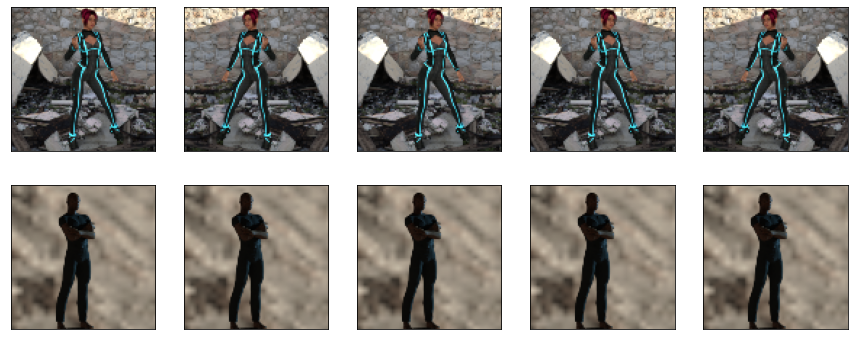

In [5]:
import tensorflow as tf
import matplotlib.pyplot as plt
ds=train_hh.shuffle(1000,reshuffle_each_iteration=False)
ds=ds.take(2).repeat(5)
ds=ds.map(lambda x: preprocess(x,size=(100,100)))
fig=plt.figure(figsize=(15,6))
for j,ex in enumerate(ds):
    ax=fig.add_subplot(2,5,j//2+(j%2)*5+1)
    ax.set_xticks([]);ax.set_yticks([])
    ax.imshow(ex[0])

plt.show()

In [6]:
import numpy as np
BATCH_SIZE=100
BUFFER_SIZE=100
IMAGE_SIZE=(150,150)
steps_per_epoch=np.ceil(1000/BATCH_SIZE)
ds_train=train_hh.map(lambda x: preprocess(x,size=IMAGE_SIZE))
ds_train=ds_train.shuffle(buffer_size=BUFFER_SIZE).repeat()
ds_train=ds_train.batch(BATCH_SIZE)
ds_valid=test_hh.map(lambda x: preprocess(x,size=IMAGE_SIZE
                                          # ,mode='eval'
                                          ))
ds_valid=ds_valid.batch(BATCH_SIZE)


In [7]:
ds_train


<BatchDataset element_spec=(TensorSpec(shape=(None, 150, 150, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [8]:
"""большое количество параметров приводит к большим потерям и малой точности"""
from tensorflow.keras.layers import Dense,Dropout,Conv2D, MaxPool2D,Flatten

model=tf.keras.Sequential()
model.add(Conv2D(
    filters=32,kernel_size=(3,3),
    padding='same',
    name='conv_1',activation='relu',activity_regularizer='l2'
))
model.add(MaxPool2D(
    pool_size=(2,2),name='pool_1',
))

model.add(Dropout(
    0.5
))

model.add(Conv2D(
    filters=64,kernel_size=(3,3),
    padding='same',
    name='conv_2',activation='relu',activity_regularizer='l2'
))
model.add(MaxPool2D(
    pool_size=(2,2),name='pool_2'
))

model.add(Dropout(
    0.5
))

model.add(Conv2D(
    filters=64,kernel_size=(3,3),
    padding='same',
    name='conv_3',activation='relu',activity_regularizer='l2'
))
model.add(MaxPool2D(
    pool_size=(2,2),name='pool_3'
))

model.add(Conv2D(
    filters=64,kernel_size=(3,3),
    padding='same',
    name='conv_4',activation='relu',activity_regularizer='l2'
))
model.add(MaxPool2D(
    pool_size=(2,2),name='pool_4'
))

model.add(Conv2D(
    filters=64,kernel_size=(3,3),
    padding='same',
    name='conv_5',activation='relu',activity_regularizer='l2'
))
model.add(MaxPool2D(
    pool_size=(2,2),name='pool_5'
))

model.add(Dropout(
    0.5
))

# model.add(Conv2D(
#     filters=64,kernel_size=(3,3),
#     padding='same',
#     name='conv_6',activation='relu',
# ))
# model.add(MaxPool2D(
#     pool_size=(2,2),name='pool_6'
# ))
# model.compute_output_shape(input_shape=(None, 300, 300, 3))

In [9]:
from tensorflow.keras.layers import GlobalAvgPool2D,Flatten

# model.add(GlobalAvgPool2D())#вычисляет среднее каждого канала
model.add(Flatten())
model.compute_output_shape(input_shape=(None, 150, 150, 3))

TensorShape([None, 1024])

In [10]:
model.add(Dense(
    1024,name='fc_1',activation="relu",activity_regularizer='l2'
))
model.add(Dropout(
    0.2
))
model.add(Dense(
    16,activation="relu",activity_regularizer='l2'
))
model.add(Dense(
    1,activation='sigmoid'
))
model.build(input_shape=(None, 150, 150, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv_1 (Conv2D)             (None, 150, 150, 32)      896       
                                                                 
 pool_1 (MaxPooling2D)       (None, 75, 75, 32)        0         
                                                                 
 dropout (Dropout)           (None, 75, 75, 32)        0         
                                                                 
 conv_2 (Conv2D)             (None, 75, 75, 64)        18496     
                                                                 
 pool_2 (MaxPooling2D)       (None, 37, 37, 64)        0         
                                                                 
 dropout_1 (Dropout)         (None, 37, 37, 64)        0         
                                                                 
 conv_3 (Conv2D)             (None, 37, 37, 64)        3

In [13]:
model.compile(
    optimizer=tf.keras.optimizers.RMSprop(learning_rate=0.0001),
    loss=tf.losses.BinaryFocalCrossentropy(from_logits=True),
              metrics=['binary_accuracy']
)
history=model.fit(
    ds_train,epochs=50,
    validation_data=ds_valid,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/50
10/10 [==============================] - 26s 2s/step - loss: 0.1035 - binary_accuracy: 0.8830 - val_loss: 0.1795 - val_binary_accuracy: 0.8086
Epo

C:\Users\karim\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


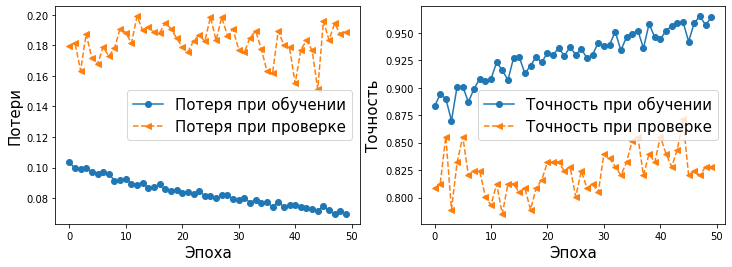

In [15]:

import matplotlib.pyplot as plt
import numpy as np
hist=history.history
x_arr=np.arange(len(hist['loss']))
fig=plt.figure(figsize=(12,4))
ax=fig.add_subplot(1,2,1)
ax.plot(x_arr,hist['loss'],'-o',label='Потеря при обучении')
ax.plot(x_arr,hist['val_loss'],'--<',label='Потеря при проверке')
ax.legend(fontsize=15)
ax.set_xlabel("Эпоха",size=15)
ax.set_ylabel("Потери",size=15)


ax=fig.add_subplot(1,2,2)
ax.plot(x_arr,hist['binary_accuracy'],'-o',label='Точность при обучении')
ax.plot(x_arr,hist['val_binary_accuracy'],'--<',label='Точность при проверке')
ax.legend(fontsize=15)
ax.set_xlabel("Эпоха",size=15)
ax.set_ylabel("Точность",size=15)
plt.show()

In [16]:
"""Рекуррентные нейронные сети"""

rnn = tf.keras.layers.SimpleRNN(
    units=2,use_bias=True,return_sequences=True
)
rnn.build(input_shape=(None,None,5))
"""(None,None,5) - первое измерение - измерение пакета,
второе измерение - последовательность, третье - признаки,
None означает переменный размер"""
w_xh,w_oo,b_h=rnn.weights
print(f"w_xh {w_xh.shape}")
print(f"w_oo {w_oo.shape}")
print(f"b_h {b_h.shape}")

w_xh (5, 2)
w_oo (2, 2)
b_h (2,)


In [17]:
x_seq = tf.convert_to_tensor(
    [[1.]*5,[2.]*5,[3.]*5],
    dtype=tf.float32
)
output = rnn(tf.reshape(x_seq,shape=(1,3,5)))
out_man=[]
for t in range(len(x_seq)):
    xt=tf.reshape(x_seq[t],(1,5))
    print(f"Временной шаг {t}")
    print(f"Вход {xt.numpy()}")

    ht = tf.matmul(xt,w_xh)+b_h
    print(f"Скрытый слой {ht.numpy()}")

    if t>0:
        prev_o = out_man[t-1]
    else:
        prev_o = tf.zeros(shape=(ht.shape))
    ot=ht+tf.matmul(prev_o,w_oo)
    ot=tf.math.tanh(ot)
    out_man.append(ot)
    print(f"Вручную {ot.numpy()}")
    print(f"SimpleRNN {t},{output[0][t].numpy()}")

Временной шаг 0
Вход [[1. 1. 1. 1. 1.]]
Скрытый слой [[-0.25954854  0.77403766]]
Вручную [[-0.2538732   0.64927113]]
SimpleRNN 0,[-0.2538732   0.64927113]
Временной шаг 1
Вход [[2. 2. 2. 2. 2.]]
Скрытый слой [[-0.5190971  1.5480753]]
Вручную [[0.15135448 0.93963945]]
SimpleRNN 1,[0.15135448 0.93963945]
Временной шаг 2
Вход [[3. 3. 3. 3. 3.]]
Скрытый слой [[-0.7786455  2.3221133]]
Вручную [[0.13993688 0.9690506 ]]
SimpleRNN 2,[0.13993688 0.9690506 ]


In [21]:
import pandas as pd
import os
import pyprind
basepath="archives/aclImdb_v1/aclImdb"
labels = {"pos":1,"neg":0}
pbar=pyprind.ProgBar(50000)
df=pd.DataFrame()
for i in ("test","train"):
    for l in ("pos","neg"):
        path=os.path.join(basepath,i,l)
        for file in sorted(os.listdir(path)):
            with open(os.path.join(path,file),"r",encoding="utf-8") as infile:
                txt=infile.read()
            df = df.append([[txt,labels[l]]],ignore_index=True)
            pbar.update()
df.columns=['review','sentiment']

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:01:54


In [22]:
np.random.seed(0)
df=df.reindex(np.random.permutation(df.index))
df.to_csv("movie.csv",index=False,encoding='utf-8')


In [23]:
df.head(10)
# 318

,review,sentiment
11841,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
19602,OK... so... I really like Kris Kristofferson a...,0
45519,"***SPOILER*** Do not read this, if you think a...",0
25747,hi for all the people who have seen this wonde...,1
42642,"I recently bought the DVD, forgetting just how...",0
31902,Leave it to Braik to put on a good show. Final...,1
30346,Nathan Detroit (Frank Sinatra) is the manager ...,1
12363,"To understand ""Crash Course"" in the right cont...",1
32490,I've been impressed with Chavez's stance again...,1
26128,This movie is directed by Renny Harlin the fin...,1


In [1]:
import pandas as pd
df = pd.read_csv("movie.csv")
df.head(5)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [4]:
import datetime
df['datetime']=str(datetime.datetime.now())
df.head(5)

,review,sentiment,datetime
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1,2022-05-26 18:50:58.745205
1,OK... so... I really like Kris Kristofferson a...,0,2022-05-26 18:50:58.745205
2,"***SPOILER*** Do not read this, if you think a...",0,2022-05-26 18:50:58.745205
3,hi for all the people who have seen this wonde...,1,2022-05-26 18:50:58.745205
4,"I recently bought the DVD, forgetting just how...",0,2022-05-26 18:50:58.745205


In [6]:
df[df.columns.difference(['datetime', 'D'])]

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0
...,...,...
49995,"OK, lets start with the best. the building. al...",0
49996,The British 'heritage film' industry is out of...,0
49997,I don't even know where to begin on this one. ...,0
49998,Richard Tyler is a little boy who is scared of...,0


In [17]:
'[asdas--]'.replace('[','')

'[asdas--]'

In [28]:
print(str(datetime.datetime.now()).split('.'))
print(str(datetime.datetime.now()))

['2022-05-26 19:30:55', '581302']
2022-05-26 19:30:55.581302


In [30]:
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
count = CountVectorizer(stop_words=['is','the','and'])
docs = np.array([
    'the sun is shunning',
    'the weaver is sweet',
    'the sun is shunning the weaver is sweet and one plus one equals two'
])
bag = count.fit_transform(docs)
bag

<3x8 sparse matrix of type '<class 'numpy.int64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [31]:
bag.toarray()


array([[0, 0, 0, 1, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 1],
       [1, 2, 1, 1, 1, 1, 1, 1]], dtype=int64)

In [32]:
count.vocabulary_


{'sun': 4,
 'shunning': 3,
 'weaver': 7,
 'sweet': 5,
 'one': 1,
 'plus': 2,
 'equals': 0,
 'two': 6}

In [33]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidf = TfidfTransformer(use_idf=True,norm='l2',smooth_idf=True)
tfidf.fit_transform(bag).toarray()

array([[0.        , 0.        , 0.        , 0.70710678, 0.70710678,
        0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.70710678, 0.        , 0.70710678],
       [0.32767345, 0.65534691, 0.32767345, 0.24920411, 0.24920411,
        0.24920411, 0.32767345, 0.24920411]])

In [20]:
tfidf


TfidfTransformer()

In [34]:
df.loc[0,'review'][-50:]


'zation my vote is seven title brazil not available'

In [35]:
import re
def clean_text(text):
    text = re.sub('<[^>]*','',text)
    emotions = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text)
    text = re.sub('[\W]+',' ',text.lower())+' '.join(emotions).replace('-','')
    return text
clean_text(df.loc[0,'review'][-50:])

'zation my vote is seven title brazil not available'

In [36]:
df['review']=df['review'].apply(clean_text)
df['review']

0        in 1974 the teenager martha moxley maggie grac...
1        ok so i really like kris kristofferson and his...
2         spoiler do not read this if you think about w...
3        hi for all the people who have seen this wonde...
4        i recently bought the dvd forgetting just how ...
                               ...                        
49995    ok lets start with the best the building altho...
49996    the british heritage film industry is out of c...
49997    i don t even know where to begin on this one i...
49998    richard tyler is a little boy who is scared of...
49999    i waited long to watch this movie also because...
Name: review, Length: 50000, dtype: object

In [29]:
from nltk.stem.porter import PorterStemmer
"""стемминг - поиск однокоренных слов"""
porter = PorterStemmer()
def tokenizer_porter(text:str)->list:
    return [porter.stem(world) for world in text.split()]
tokenizer_porter('runners like running and thus they run')


['runner', 'like', 'run', 'and', 'thu', 'they', 'run']

In [37]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\karim\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\stopwords.zip.


True

In [39]:
from nltk.corpus import stopwords
stop = stopwords.words('english')
[w for w in tokenizer_porter('a runners like running and'
                             ' thus they run a lot') if w not in stop]

['runner', 'like', 'run', 'thu', 'run', 'lot']

In [40]:
X_train = df.loc[:25000,'review'].values
X_test = df.loc[25000:,'review'].values
y_train = df.loc[:25000,'sentiment'].values
y_test = df.loc[25000:,'sentiment'].values

In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(strip_accents=None,lowercase=False,preprocessor=None)
param_grid=[{'vect__ngram_range':[(1,1)],
             'vect__stop_words':[stop,None],
             'vect__tokenizer':[tokenizer_porter,clean_text],
             'clf__penalty':['l1','l2'],
             'clf__C':[1.,10.,100.]},
            {'vect__ngram_range':[(1,1)],
             'vect__stop_words':[stop,None],
             'vect__tokenizer':[tokenizer_porter,clean_text],
             'clf__penalty':['l1','l2'],
             'clf__C':[1.,10.,100.],
            'vect__use_idf':[False],
             'vect__norm':[None]
            }
            ]
lr_tfidf = Pipeline([('vect',tfidf),
                     ('clf',LogisticRegression(
                         random_state=0,solver='liblinear'
                     ))])
gs_lr_tfidf = GridSearchCV(lr_tfidf,param_grid,scoring='accuracy',cv=5,
                           verbose=2,n_jobs=-1)
gs_lr_tfidf.fit(X_train,y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect',
                                        TfidfVectorizer(lowercase=False)),
                                       ('clf',
                                        LogisticRegression(random_state=0,
                                                           solver='liblinear'))]),
             n_jobs=-1,
             param_grid=[{'clf__C': [1.0, 10.0, 100.0],
                          'clf__penalty': ['l1', 'l2'],
                          'vect__ngram_range': [(1, 1)],
                          'vect__stop_words': [['i', 'me', 'my', 'myself', 'we',
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've...
                                                'our', 'ours', 'ourselves',
                                                'you', "you're", "you've",
                                                "you'll", "you'd", 'your',
 

In [43]:
gs_lr_tfidf.best_params_



{'clf__C': 10.0,
 'clf__penalty': 'l2',
 'vect__ngram_range': (1, 1),
 'vect__stop_words': None,
 'vect__tokenizer': <function __main__.tokenizer_porter(text: str) -> list>}

In [44]:
gs_lr_tfidf.best_score_


0.8914443671265747

In [46]:
clf=gs_lr_tfidf.best_estimator_
clf

Pipeline(steps=[('vect',
                 TfidfVectorizer(lowercase=False,
                                 tokenizer=<function tokenizer_porter at 0x000001C26848C0D0>)),
                ('clf',
                 LogisticRegression(C=10.0, random_state=0,
                                    solver='liblinear'))])

In [47]:
clf.score(X_test,y_test)


0.89368

In [24]:
import pandas as pd
import numpy as np
from nltk.corpus import stopwords
import re
stop = stopwords.words('english')
def clean_text(text):
    text = re.sub('<[^>]*>','',text)
    emotions = re.findall('(?::|;|=)(?:-)?(?:\)|\(|D|P)',text.lower())
    text = re.sub('[\W]+',' ',text.lower())+' '.join(emotions).replace('-','')
    tokenized = [w for w in text.split() if w not in stop]
    return tokenized
def stream_docs(path):
    with open(path,"r",encoding='utf-8') as csv:
        next(csv)
        for line in csv:
            text,label = line[:-3],int(line[-2])
            yield text,label

In [25]:
a=stream_docs("movie.csv")

In [26]:
next(a)

('"In 1974, the teenager Martha Moxley (Maggie Grace) moves to the high-class area of Belle Haven, Greenwich, Connecticut. On the Mischief Night, eve of Halloween, she was murdered in the backyard of her house and her murder remained unsolved. Twenty-two years later, the writer Mark Fuhrman (Christopher Meloni), who is a former LA detective that has fallen in disgrace for perjury in O.J. Simpson trial and moved to Idaho, decides to investigate the case with his partner Stephen Weeks (Andrew Mitchell) with the purpose of writing a book. The locals squirm and do not welcome them, but with the support of the retired detective Steve Carroll (Robert Forster) that was in charge of the investigation in the 70\'s, they discover the criminal and a net of power and money to cover the murder.<br /><br />""Murder in Greenwich"" is a good TV movie, with the true story of a murder of a fifteen years old girl that was committed by a wealthy teenager whose mother was a Kennedy. The powerful and rich f

In [27]:
def get_minibatch(doc_stream,size):
    docs,y =[],[]
    try:
        for _ in range(size):
            text,label = next(doc_stream)
            docs.append(text)
            y.append(label)
    except StopIteration:
        return None,None
    return docs,y



In [28]:
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.linear_model import SGDClassifier
vect = HashingVectorizer(
    decode_error='ignore',
    n_features=2**21,
    preprocessor=None,
    tokenizer=clean_text
)
clf = SGDClassifier(loss='log',random_state=1)
doc_stream = stream_docs(path='movie.csv')


In [29]:
import pyprind
pbar = pyprind.ProgBar(45)
classes = np.array([0,1])
for _ in range(45):
    X_train,y_train = get_minibatch(doc_stream,size=1000)
    if not X_train:
        break
    X_train = vect.transform(X_train)
    clf.partial_fit(X_train,y_train,classes=classes)#обучение через генератор
    pbar.update()


0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:00:21


In [30]:
X_test,y_test = get_minibatch(doc_stream,size=5000)
X_test = vect.transform(X_test)

In [31]:
clf.score(X_test,y_test)

0.8682

In [34]:
import pandas as pd
from sklearn.feature_extraction.text import CountVectorizer
df = pd.read_csv('movie.csv')
count = CountVectorizer(stop_words='english',max_df=.1,max_features=5000)
 #частота слов max_df
X = count.fit_transform(df['review'].values)
X.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [35]:
X.shape


(50000, 5000)

In [36]:
from sklearn.decomposition import LatentDirichletAllocation
lda = LatentDirichletAllocation(n_components=10,
                                random_state=1,
                                learning_method='batch') #online для генераторов
X_tops = lda.fit_transform(X)

In [84]:
X_tops

array([[0.11366427, 0.00111137, 0.03270236, ..., 0.0537207 , 0.03205699,
        0.00111132],
       [0.00158768, 0.8004565 , 0.00158765, ..., 0.00158763, 0.00158772,
        0.00158776],
       [0.38222972, 0.37493821, 0.00119094, ..., 0.00119089, 0.00119077,
        0.234496  ],
       ...,
       [0.00277929, 0.4367985 , 0.00277837, ..., 0.0027783 , 0.2507384 ,
        0.0027786 ],
       [0.31118012, 0.00384737, 0.00384708, ..., 0.00384746, 0.33013966,
        0.00384678],
       [0.2584659 , 0.1668546 , 0.00833561, ..., 0.0083357 , 0.00833414,
        0.51633413]])

In [ ]:
lda.components_

In [74]:
lda.components_.shape

(10, 5000)

In [86]:
X_tops[:,5].argsort()
# X_tops[:,5].argsort() - возвращает индексы сортирующего массива

0.7622988165603738

In [83]:
count.get_feature_names()[150:155]

c:\users\karim\pycharmprojects\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


'father'

In [78]:
t.argsort()

array([4983, 2723, 1130, ..., 1702, 2947, 1682], dtype=int64)

In [81]:
t.argsort()[:-2:-1]

array([1682], dtype=int64)

In [76]:
n_top_words=2
t=lda.components_[0]
[count.get_feature_names()[i] for i in t.argsort()[:-n_top_words-1:-1]]

c:\users\karim\pycharmprojects\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


['wwe',
 'lugosi',
 'custer',
 'bela',
 'fulci',
 'bettie',
 'spock',
 'bronson',
 'astaire',
 'giallo',
 'damme',
 'karloff',
 'bourne',
 'commander',
 'powell',
 'stooges',
 'hartley',
 'widmark',
 'argento',
 'lemmon',
 'connery',
 'boll',
 'assassination',
 'che',
 'seagal',
 'splatter',
 'snipes',
 'werewolf',
 'dracula',
 'uwe',
 'zombies',
 'stan',
 'lincoln',
 'sci',
 'lance',
 'norris',
 'westerns',
 'bogart',
 'chaplin',
 'ninja',
 'davies',
 'matthau',
 'hitler',
 'fi',
 'vampires',
 'gags',
 'laurel',
 'heist',
 'martial',
 'sinatra',
 'scarecrow',
 'germans',
 'caine',
 'rourke',
 'comedians',
 'communist',
 'chess',
 'kung',
 'kirk',
 'assassin',
 'gore',
 'fu',
 'global',
 'cusack',
 'cia',
 'propaganda',
 'soviet',
 'prisoners',
 'carrey',
 'slasher',
 'zombie',
 'li',
 'rochester',
 'troops',
 'tarantino',
 'mst3k',
 'futuristic',
 'unwatchable',
 'columbo',
 'julian',
 'macbeth',
 'rita',
 'spoof',
 'carradine',
 'perry',
 'welles',
 'kubrick',
 'abysmal',
 'laughably

In [63]:
n_top_words = 5
f_names = count.get_feature_names()
# print(f_names)
for top_idx,top in enumerate(lda.components_):
    print(f"Тема {top_idx+1}:")
    print(" ".join([f_names[i] for i in top.argsort()[:-n_top_words-1:-1]]))

Тема 1:
family mother father children kids
Тема 2:
worst minutes money awful terrible
Тема 3:
book read game novel version
Тема 4:
horror budget audience original low
Тема 5:
music action performance musical role
Тема 6:
wife role woman plays john
Тема 7:
war american men history human
Тема 8:
series tv episode dvd episodes
Тема 9:
horror guy effects killer dead
Тема 10:
comedy humor laugh fun jokes


c:\users\karim\pycharmprojects\venv\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [65]:
horror = X_tops[:,3].argsort()[::-1] # берём колонку ужасы
print(horror)
print(horror[:3]) # берём индексы первых трёх ужастиков
for idx,m_idx in enumerate(horror[:3]):
    print(f"Фильм ужасов {idx+1}:")
    print(df['review'][m_idx][:300],"...")

[49135  9988 45437 ... 31616 15111 25114]
[49135  9988 45437]
Фильм ужасов 1:
As a low budget enterprise in which the filmmakers themselves are manufacturing and distributing the DVDs themselves, we perhaps shouldn't expect too much from Broken in disc form. And yet what's most remarkable about this whole achievement is the fact that this release comes with enough extras to s ...
Фильм ужасов 2:
As a low budget enterprise in which the filmmakers themselves are manufacturing and distributing the DVDs themselves, we perhaps shouldn't expect too much from Broken in disc form. And yet what's most remarkable about this whole achievement is the fact that this release comes with enough extras to s ...
Фильм ужасов 3:
This movie certainly deserves to be placed within the genre of horror, but not for obvious reasons. The horror of "A Tale Of Two Sisters" lies not with sudden shocks or large helpings of CGI guts and gore; it is a psychological horror movie which piques the viewer's curiosity fro

In [1]:
import tensorflow as tf
import pandas as pd
df = pd.read_csv('movie.csv',encoding='utf-8')
df.head(5)

,review,sentiment
0,"In 1974, the teenager Martha Moxley (Maggie Gr...",1
1,OK... so... I really like Kris Kristofferson a...,0
2,"***SPOILER*** Do not read this, if you think a...",0
3,hi for all the people who have seen this wonde...,1
4,"I recently bought the DVD, forgetting just how...",0


In [2]:
target = df.pop('sentiment')

In [3]:
df.head(2)

,review
0,"In 1974, the teenager Martha Moxley (Maggie Gr..."
1,OK... so... I really like Kris Kristofferson a...


In [4]:
ds_raw = tf.data.Dataset.from_tensor_slices((df.values,target.values))
for ex in ds_raw.take(3):
    tf.print(ex[0].numpy()[0][:50],ex[1])

b'In 1974, the teenager Martha Moxley (Maggie Grace)' 1
b'OK... so... I really like Kris Kristofferson and h' 0
b'***SPOILER*** Do not read this, if you think about' 0


In [5]:
"""Делим датасет на тренировочный, тестовый и валидационный"""
tf.random.set_seed(1)
ds_raw = ds_raw.shuffle(50000,reshuffle_each_iteration=False)
ds_raw_test = ds_raw.take(25000)
ds_raw_train_valid = ds_raw.skip(25000)
ds_raw_train = ds_raw_train_valid.take(20000)
ds_raw_valid = ds_raw_train_valid.skip(20000)

In [6]:
from collections import Counter
import tensorflow_datasets as tfds
tokenizer = tfds.deprecated.text.Tokenizer()
token_counts = Counter()
for example in ds_raw_train:
    tokens = tokenizer.tokenize(example[0].numpy()[0]) #делит текст по словам
    token_counts.update(tokens) #считает уникальные слова
token_counts

Counter({'okay': 367,
         'this': 48128,
         'movie': 34933,
         'f': 141,
         'ck': 19,
         'in': 69251,
         'rules': 141,
         'it': 61393,
         'is': 82786,
         'without': 2360,
         'question': 479,
         'one': 19000,
         'of': 113237,
         'the': 228090,
         'most': 6463,
         'technically': 85,
         'inept': 133,
         'pieces': 343,
         'cinema': 1081,
         'ever': 4440,
         'made': 6312,
         'absolutely': 1200,
         'terrible': 1203,
         'but': 27541,
         'you': 24568,
         'GOTTA': 2,
         'see': 8810,
         'rent': 543,
         'with': 33760,
         'your': 4356,
         'buddies': 71,
         'and': 123331,
         'come': 2329,
         'up': 10374,
         'a': 122891,
         'drinking': 120,
         'game': 1007,
         'or': 13631,
         'just': 13021,
         'have': 21994,
         'fun': 2045,
         's': 48923,
         'hilarious'

In [7]:
len(token_counts)


87007

In [8]:
#кодирование уникальных лексемм
encoder = tfds.deprecated.text.TokenTextEncoder(token_counts)
example_str = "This is example!"
encoder.encode(example_str)


[232, 9, 1123]

In [9]:
next(iter(ds_raw_train))[0].numpy()[0]

b'okay, this movie f*ck in\' rules. it is without question one of the most technically inept pieces of cinema ever made. absolutely terrible, but you GOTTA see it. rent this with your buddies and come up with a drinking game or just have fun, it\'s hilarious. and the behind-the-scenes featurette proves it, you can do anything with paper plates and finger paint. awesome. okay, rent it just for this one scene: two characters are actually WALKING IN PLACE for about 3 minutes in a shot. the director (on the commentary) says "yeah, the tracking was so smooth it looks like they\'re...". yeah, right man, they are totally walking in place. it\'s so funny.'

In [10]:
def encode(text_tensor,label):
    """Декодирует текстовый тензор в лист индексов слов"""
    text = text_tensor.numpy()[0]
    encoded_text = encoder.encode(text)
    return encoded_text,label

def encode_map_fn(text,label):
    """Завертывает питоновскую функцию в tensorflow"""
    return tf.py_function(encode,inp=[text,label],Tout=(tf.int64,tf.int64))

ds_train = ds_raw_train.map(encode_map_fn)
ds_valid = ds_raw_valid.map(encode_map_fn)
ds_test = ds_raw_test.map(encode_map_fn)

In [22]:
for example in ds_train.shuffle(1000).take(5):
    print(example[0].shape)

(<tf.Tensor: shape=(158,), dtype=int64, numpy=
array([ 1562,  1557,   156,  2701,  1233,   795,    14, 11791,     9,
          29,     2,     3,    24,  1562,    48,  1100,    25,   117,
        1562,    75,  5472,  4103,   100,     2,     3,    14,   442,
          13, 14246,   404,  1442,   100,  7834,  7835,  7836,    75,
          12,    13,    14,    15,  2694,   435,  1873,    59,     6,
        5530,  2312,     2,     3,  6900,   435,  4290,    96,  1279,
       13226,    96,    14,   618,     8,    21,   343,   225,    21,
         343,  5274,    21,   343,   717,  4817,    32,  1643,    96,
         173,  8290,    14,   155,    96,   810,    14,     3,     8,
         563,   480,   155,    96,   648,   703,     9,   133,    70,
          32,   563,    25,    70,    35,  8046,  8047,   331,    13,
        5833,  1074,  3573,  1562,   511,  1562,  1393,   429,  1118,
        4818,  1562,   641,   257,   990,     8,   186,   312,  1562,
         613,     2,  2608,  2514,   212,  

In [12]:
"""Размер у каждого набора разный - для того, чтобы привести к единому размеру,
используем batch_padded который заполняет пропуски нулями"""
ds_subset = ds_train.take(8)
for ex in ds_subset:
    print('не забатченный',ex[0].shape)
ds_batched = ds_subset.padded_batch(4,padded_shapes=([-1],[]))
for batch in ds_batched:
    print('забатченный',batch[0].shape)



не забатченный (119,)
не забатченный (688,)
не забатченный (308,)
не забатченный (204,)
не забатченный (326,)
не забатченный (240,)
не забатченный (127,)
не забатченный (453,)
забатченный (4, 688)
забатченный (4, 453)


In [13]:
train_data = ds_train.padded_batch(32,padded_shapes=([-1],[]))
valid_data = ds_valid.padded_batch(32,padded_shapes=([-1],[]))
test_data = ds_test.padded_batch(32,padded_shapes=([-1],[]))

In [14]:
"""Embedding - слой вложения"""
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Embedding,SimpleRNN

model = Sequential()
model.add(Embedding(
    input_dim=1000, # размер целочисленных уникальных значений,
    output_dim=32 #размер признаков вложения
))
model.add(SimpleRNN(32,return_sequences=True))
model.add(SimpleRNN(32))
model.add(Dense(1))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          32000     
                                                                 
 simple_rnn (SimpleRNN)      (None, None, 32)          2080      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 32)                2080      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 36,193
Trainable params: 36,193
Non-trainable params: 0
_________________________________________________________________


In [15]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense,Embedding,SimpleRNN,Bidirectional,LSTM
embedding_dim = 20
vocab_size = len(token_counts)+2
model = Sequential()
model.add(Embedding(
    input_dim=vocab_size, # размер целочисленных уникальных значений,
    output_dim=embedding_dim, #размер признаков вложения
    name = 'embedded-layer'
 ))
model.add(Bidirectional( #для того, чтобы рекурентный слой шёл туда и обратно по псоледовательности
    LSTM(
        64,
        name='lstm-layers'
    ),
    name = 'bidir-lstm'
))
model.add(Dense(64,activation='relu'))
model.add(Dense(1,activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedded-layer (Embedding)  (None, None, 20)          1740180   
                                                                 
 bidir-lstm (Bidirectional)  (None, 128)               43520     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 1,792,021
Trainable params: 1,792,021
Non-trainable params: 0
_________________________________________________________________


In [16]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(train_data,validation_data=valid_data,epochs=10)



Epoch 1/10
625/625 [==============================] - 208s 328ms/step - loss: 0.4937 - accuracy: 0.7590 - val_loss: 0.3507 - val_accuracy: 0.8586

C:\Users\karim\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


In [23]:
test_res = model.evaluate(test_data)
test_res[0]

782/782 [==============================] - 20s 26ms/step - loss: 0.7585 - accuracy: 0.8164

0.7584895491600037

In [24]:
test_res[1]

0.8163599967956543

In [53]:
from collections import Counter
def preprocess_datasets(
        ds_raw_train,
        ds_raw_valid,
        ds_raw_test,
        max_seqq_len=None,
        batch_size=32
):
    """Объединяет шаги - есть возможность отбора только
    последних абзацев рецензий"""

    #нахождение уникальных слов
    tokenizer = tfds.deprecated.text.Tokenizer()
    tok_counts = Counter()
    for ex in ds_raw_train:
        tokens = tokenizer.tokenize(ex[0].numpy()[0])
        if max_seqq_len is not None:
            tokens = tokens[-max_seqq_len:]
        tok_counts.update(tokens)
    print(f'Размер словаря {len(tok_counts)}')

    #кодирование текста
    encoder =  tfds.deprecated.text.TokenTextEncoder(token_counts)
    def encode1(text_tensor,label):
        text = text_tensor.numpy()[0]
        encoded_text = encoder.encode(text)
        if max_seqq_len is not None:
            encoded_text = encoded_text[-max_seqq_len:]
        return encoded_text,label
    def encoded_map_fn1(text,label):
        return tf.py_function(encode1,inp=[text,label],Tout=(tf.int64,tf.int64))

    ds_train = ds_raw_train.map(encoded_map_fn1)
    ds_test = ds_raw_test.map(encoded_map_fn1)
    ds_valid = ds_raw_valid.map(encoded_map_fn1)

    #создание пакетов для набора данных
    train_data = ds_train.padded_batch(batch_size,padded_shapes=([-1],[]))
    valid_data = ds_valid.padded_batch(batch_size,padded_shapes=([-1],[]))
    test_data = ds_test.padded_batch(batch_size,padded_shapes=([-1],[]))
    return train_data,valid_data,test_data,len(tok_counts)

In [63]:
from tensorflow.keras.layers import GRU
def build_rnn_model(embedding_dim,vocab_size,recc_type='SimpleRNN',
                    n_recc_units=64,n_recc_layers=1,bidirectional=True):
    tf.random.set_seed(1)
    model_new= Sequential()
    model_new.add(Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim
    ))
    for i in range(n_recc_layers):
        return_sequences = (i<n_recc_layers-1)
        if recc_type=='SimpleRNN':
            recc_layer= SimpleRNN(units=n_recc_units,
                                  return_sequences=return_sequences,name=f"layers{i+1}")
        elif recc_type=='LSTM':
            recc_layer= LSTM(units=n_recc_units,
                                  return_sequences=return_sequences)
        elif recc_type=='GRU':
            recc_layer= GRU(units=n_recc_units,
                                  return_sequences=return_sequences)
        if bidirectional:
            recc_layer=Bidirectional(recc_layer)
        model_new.add(recc_layer)
    model_new.add(Dense(64,activation='relu'))
    model_new.add(Dense(1,activation='sigmoid'))
    return model_new

In [64]:
batch_size = 32
embedding_dim=20
max_seqq_len=100
train_data,valid_data,test_data,n = preprocess_datasets(
    ds_raw_train,ds_raw_valid,ds_raw_test,max_seqq_len=max_seqq_len,
    batch_size=batch_size
)

Размер словаря 58063


In [56]:
for example in train_data.shuffle(1000).take(5):
    print(example[0].shape)

(32, 100)
(32, 100)
(32, 100)
(32, 100)
(32, 100)


In [73]:
vocab_size=n*2
rnn_model = build_rnn_model(embedding_dim=embedding_dim,vocab_size=vocab_size,
                            recc_type='SimpleRNN',n_recc_units=64,
                            n_recc_layers=1,bidirectional=True)
rnn_model.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_16 (Embedding)    (None, None, 20)          2322520   
                                                                 
 bidirectional_9 (Bidirectio  (None, 128)              10880     
 nal)                                                            
                                                                 
 dense_31 (Dense)            (None, 100)               12900     
                                                                 
 dense_32 (Dense)            (None, 1)                 101       
                                                                 
Total params: 2,346,401
Trainable params: 2,346,401
Non-trainable params: 0
_________________________________________________________________


In [74]:
rnn_model.compile(optimizer=tf.keras.optimizers.Adam(1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [75]:
history = rnn_model.fit(train_data,validation_data=valid_data,epochs=10)


Epoch 1/10
625/625 [==============================] - 39s 58ms/step - loss: 0.7045 - accuracy: 0.5021 - val_loss: 0.6999 - val_accuracy: 0.4934

C:\Users\karim\AppData\Roaming\Python\Python39\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


In [76]:
res=rnn_model.evaluate(test_data)
res[1]*100

782/782 [==============================] - 16s 21ms/step - loss: 0.9740 - accuracy: 0.8002

80.02399802207947

In [1]:
import numpy as np
with open('books/1268-0.txt','r',encoding="utf-8") as fp:
    text = fp.read()
start_index = text.find('The Mysterious Island')
end_index = text.find('End of the Project')
text = text[start_index:end_index]
char_set = set(text)
print(f"Общая длина текста книги:{len(text)}")
print(f"Общая длина уникального текста книги:{len(char_set)}")

Общая длина текста книги:1112885
Общая длина уникального текста книги:83


In [2]:
# sorted(char_set)

In [3]:
chars_sorted = sorted(char_set)
char2int = {ch:i for i,ch in enumerate(chars_sorted)} #индексируем каждый уникальный символ
# char_array = np.array(chars_sorted)
char2int

{'\n': 0,
 ' ': 1,
 '!': 2,
 '#': 3,
 '&': 4,
 '(': 5,
 ')': 6,
 '*': 7,
 ',': 8,
 '-': 9,
 '.': 10,
 '/': 11,
 '0': 12,
 '1': 13,
 '2': 14,
 '3': 15,
 '4': 16,
 '5': 17,
 '6': 18,
 '7': 19,
 '8': 20,
 '9': 21,
 ':': 22,
 ';': 23,
 '=': 24,
 '?': 25,
 'A': 26,
 'B': 27,
 'C': 28,
 'D': 29,
 'E': 30,
 'F': 31,
 'G': 32,
 'H': 33,
 'I': 34,
 'J': 35,
 'K': 36,
 'L': 37,
 'M': 38,
 'N': 39,
 'O': 40,
 'P': 41,
 'Q': 42,
 'R': 43,
 'S': 44,
 'T': 45,
 'U': 46,
 'V': 47,
 'W': 48,
 'Y': 49,
 'Z': 50,
 '[': 51,
 ']': 52,
 'a': 53,
 'b': 54,
 'c': 55,
 'd': 56,
 'e': 57,
 'f': 58,
 'g': 59,
 'h': 60,
 'i': 61,
 'j': 62,
 'k': 63,
 'l': 64,
 'm': 65,
 'n': 66,
 'o': 67,
 'p': 68,
 'q': 69,
 'r': 70,
 's': 71,
 't': 72,
 'u': 73,
 'v': 74,
 'w': 75,
 'x': 76,
 'y': 77,
 'z': 78,
 '‘': 79,
 '’': 80,
 '“': 81,
 '”': 82}

In [4]:
char_array = np.array(chars_sorted)
char_array

array(['\n', ' ', '!', '#', '&', '(', ')', '*', ',', '-', '.', '/', '0',
       '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '=', '?',
       'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M',
       'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'Y', 'Z', '[',
       ']', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l',
       'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y',
       'z', '‘', '’', '“', '”'], dtype='<U1')

In [5]:
text_encoded = np.array([char2int[ch] for ch in text]) #кодируем всю книгу
print(f'Размер закодированного текста: {text_encoded.shape}')
print(f'Пример {text[:15]} ==>кодирование==>{text_encoded[:15]}')
print(f"Пример {text_encoded[:15]} ==>декодирование==>{''.join(char_array[text_encoded[:15]])}")

Размер закодированного текста: (1112885,)
Пример The Mysterious  ==>кодирование==>[45 60 57  1 38 77 71 72 57 70 61 67 73 71  1]
Пример [45 60 57  1 38 77 71 72 57 70 61 67 73 71  1] ==>декодирование==>The Mysterious 


In [6]:
text_encoded[15:21]

array([34, 71, 64, 53, 66, 56])

In [7]:
import tensorflow as tf

ds_text_encoded = tf.data.Dataset.from_tensor_slices(text_encoded)
for ex in ds_text_encoded.take(5):
    print(f"{ex.numpy()}->{char_array[ex.numpy()]}")


45->T
60->h
57->e
1-> 
38->M


In [8]:
seq_lenght =40
chunk_size = seq_lenght + 1
ds_chunks = ds_text_encoded.batch(chunk_size,drop_remainder=True)
def split_input_target(chunk):
    input_seq = chunk[:-1]
    output_seq = chunk[1:]
    return input_seq, output_seq
ds_sequenses = ds_chunks.map(split_input_target)
for example in ds_sequenses.take(7):
    print(repr("".join(char_array[example[0].numpy()])))
    print(repr("".join(char_array[example[1].numpy()])))

'The Mysterious Island, by Jules Verne\n\nT'
'he Mysterious Island, by Jules Verne\n\nTh'
'is eBook is for the use of anyone anywhe'
's eBook is for the use of anyone anywher'
'e at no cost and with\nalmost no restrict'
' at no cost and with\nalmost no restricti'
'ons whatsoever.  You may copy it, give i'
'ns whatsoever.  You may copy it, give it'
' away or\nre-use it under the terms of th'
'away or\nre-use it under the terms of the'
' Project Gutenberg License included\nwith'
'Project Gutenberg License included\nwith '
'this eBook or online at www.gutenberg.or'
'his eBook or online at www.gutenberg.org'


In [9]:
BUFFER_SIZE = 1000
BATCH_SIZE = 64
ds = ds_sequenses.shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
for example in ds.take(7):
    print("".join(char_array[example[0].numpy()[1]]))

flection of light, no sound from inhabit
400 feet above the
water.

At that momen


Those whom the hurricane had just thro
ving announced to his journal the result
 dreadful than
those below, did not hesi

was intense. The castaways suffered cru
s this, gulls and sea-mews are scarcely 


In [10]:
tf.random.set_seed(1)
def build_model(vocab_size:int,embedding_dim:int,rnn_units:str):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Embedding(vocab_size,embedding_dim))
    model.add(tf.keras.layers.LSTM(rnn_units,return_sequences=True))
    model.add(tf.keras.layers.Dense(vocab_size))
    return model
charset_size = len(char_array)
embedding_dim = 256
rnn_units = 512
model = build_model(vocab_size = charset_size,
                    embedding_dim = embedding_dim,
                    rnn_units = rnn_units)
model.summary()

# в LSTM ранг 3 так как первое измерение число пакетов, второе - длину последовательности
# после LSTM ранг 3 так как он возвращает последовательности

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 256)         21248     
                                                                 
 lstm (LSTM)                 (None, None, 512)         1574912   
                                                                 
 dense (Dense)               (None, None, 83)          42579     
                                                                 
Total params: 1,638,739
Trainable params: 1,638,739
Non-trainable params: 0
_________________________________________________________________


In [11]:
model.compile(optimizer='adam',loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True))
model.fit(ds,epochs = 20)

Epoch 1/20
425/425 [==============================] - 150s 349ms/step - loss: 2.3184

In [12]:
import tensorflow as tf
logits = [[1.,2.,6.]]
print(f"Вероятности {tf.math.softmax(logits).numpy()[0]}")

Вероятности [0.00657326 0.01786798 0.9755587 ]


In [13]:
samples = tf.random.categorical(logits=logits, num_samples=10) #формирует последовательность длиной num_samples и показывает какой инедкс будет отображаться чаще
tf.print(samples.numpy())

array([[2, 2, 2, 2, 2, 0, 2, 2, 2, 2]], dtype=int64)


In [14]:
def sample(model,starting_str,len_generated_text=500,max_input_length=40,
           scale_factor=1.0):
    encoded_input = [char2int[s] for s in starting_str]
    encoded_input = tf.reshape(encoded_input,(1,-1))
    # print(encoded_input)
    generated_str = starting_str

    model.reset_states()
    for i in range(len_generated_text):
        logits = model(encoded_input)
        logits = tf.squeeze(logits,0) # уменьшает размерность

        scaled_logits = logits * scale_factor
        new_char_indx = tf.random.categorical(scaled_logits,num_samples=1)

        new_char_indx = tf.squeeze(new_char_indx)[-1].numpy()

        generated_str += str(char_array[new_char_indx])
        new_char_indx = tf.expand_dims([new_char_indx],0)

        encoded_input = tf.concat(
            [encoded_input,new_char_indx],
            axis = 1
        )
        encoded_input = encoded_input[:, -max_input_length:]
    return generated_str


In [15]:
tf.random.set_seed(1)
print(sample(model,starting_str='The island'))


The island is probable that the vigorous usual
circhmon. A few continuents, sween of Goor Captain Harding, Gideon
Spilett, who had completed towards heat of the word contacle the
sun to the bank of the island set to our the
depths of the opening of the sea.

The simple murmured layed towards a good orite inflammation and a fare
all that, the same too’s rays eccordingly, without it frightful towards the extreme last forty
feet.

Now, this lake enabled upon the captain, with a more
less of
which comeal, the


a
5
